# Field Failure Data Analysis

## Introduction

In [1]:
# Import relevant modules
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# %matplotlib notebook
# from IPython.core.interactiveshell import InteractiveShell

## Utility functions

In [2]:
def sensitivity_analysis(dataframe, c_wins, filepath):
    if(not os.path.isfile(filepath)):
        print('Creating file, this may take a while...\n')
        tuples = []

        for win in c_wins:
            tup = 1
            prev = int(dataframe.loc[0,'Timestamp'])

            for index in range(dataframe.shape[0]-1):
                succ = int(dataframe.loc[index+1,'Timestamp'])
                if  succ - prev >= win:
                    tup = tup + 1
                prev = succ

#             print(str(win)+' '+str(tup))    
            tuples.append(tup)
        
        sens_file = open(filepath, 'w')
        
        for i in range(len(c_wins)):
            sens_file.write(str(c_wins[i]) + ' ' + str(tuples[i]) + '\n')
        
        sens_file.close()
    else:
        print('File already exists!\n')

In [3]:
def tupling(dataframe, c_win):
    tup = 0
    prev = int(dataframe.loc[0,'Timestamp'])
    dataframe.loc[0,'Tuple'] = 0

    for index in range(dataframe.shape[0]-1):
        succ = int(dataframe.loc[index+1,'Timestamp'])
        if  succ - prev >= c_win:
            tup = tup + 1
        dataframe.loc[index+1,'Tuple'] = tup
        prev = succ

# Mercury

In [4]:
# Load Mercury Data
df_mercury = pd.read_csv('Dataset/MercuryErrorLog.txt', names = ['Timestamp', 'Node', 'Subsystem', 'Message'])

df_mercury.loc[:,'Node'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[1]
df_mercury.loc[:,'Subsystem'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[2]
df_mercury.loc[:,'Message'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[3]
df_mercury.loc[:,'Timestamp'] = df_mercury.loc[:,'Timestamp'].str.split(' ', n=3).str[0]

print('Log file has ' + str(df_mercury.shape[0]) + ' entries and ' + str(df_mercury.shape[1]) + ' columns.')
df_mercury.head()

Log file has 80854 entries and 4 columns.


,Timestamp,Node,Subsystem,Message
0,1167637660,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC
1,1167637660,tg-c645,PRO,Device Error Info Section
2,1167637660,tg-c645,PRO,Error Map: x
3,1167637720,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC
4,1167637720,tg-c645,PRO,Device Error Info Section


## Data Manipulation

### Temporal coalescence

#### Sensitivity analysis

File already exists!



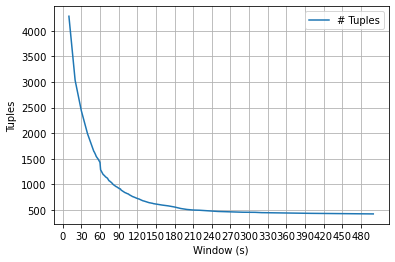

In [5]:
c_wins = np.arange(10,510,10)
accuracy = np.arange(50,150,1)
c_wins = c_wins.tolist()
c_wins.extend(accuracy)
c_wins.sort()

filepath = 'Dataset/MercurySensitivity.txt'
sensitivity_analysis(df_mercury, c_wins, filepath)

df_mercury_sensitivity = pd.read_csv(filepath, sep = ' ', names = ['Window', 'Tuples'])

plt.plot(df_mercury_sensitivity['Window'],df_mercury_sensitivity['Tuples'], label = '# Tuples')
plt.xticks(np.arange(0, 500, step = 30))
plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()

File already exists!



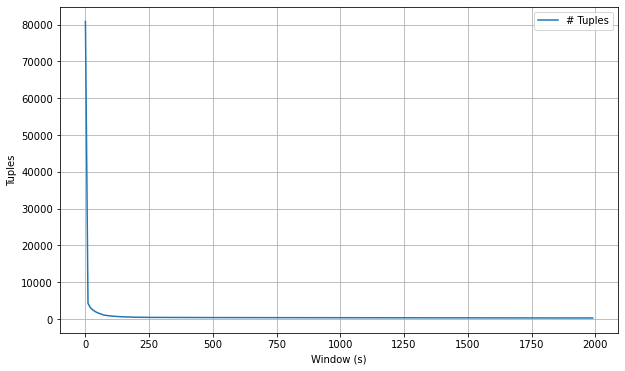

In [108]:
c_wins = np.arange(0,2000,10)

filepath = 'Dataset/MercurySensitivityAcc.txt'
sensitivity_analysis(df_mercury, c_wins, filepath)

df_mercury_sensitivity = pd.read_csv(filepath, sep = ' ', names = ['Window', 'Tuples'])

plt.figure(figsize=(10,6))

plt.plot(df_mercury_sensitivity['Window'],df_mercury_sensitivity['Tuples'], label = '# Tuples')

plt.xlabel('Window (s)')
plt.ylabel('Tuples')
plt.legend()
plt.grid()

#### Tupling

In [105]:
window = 250
tupling(df_mercury, window)

In [142]:
df_mercury = df_mercury.astype({'Tuple' : 'int32'})
df_mercury.head()

,Timestamp,Node,Subsystem,Message,Tuple
0,1167637660,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,0
1,1167637660,tg-c645,PRO,Device Error Info Section,0
2,1167637660,tg-c645,PRO,Error Map: x,0
3,1167637720,tg-c645,PRO,+BEGIN HARDWARE ERROR STATE AT CMC,0
4,1167637720,tg-c645,PRO,Device Error Info Section,0


In [141]:
print('Number of tuples: ' + str(df_mercury.max(axis = 0).loc['Tuple'] + 1))

Number of tuples: 469


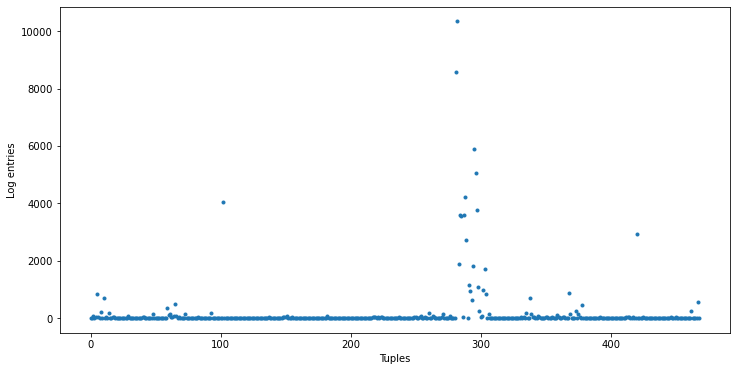

In [147]:
x = df_mercury['Tuple'].unique()
y = df_mercury.groupby(by='Tuple').Timestamp.count()

plt.figure(figsize=(12,6))

plt.scatter(x, y, marker = '.')

plt.xlabel('Tuples')
plt.ylabel('Log entries')
plt.show()

### Spatial coalescence

In [177]:
df_mercury.loc[df_mercury['Node'].str.contains('login'), 'Type'] = 'login'
df_mercury.loc[df_mercury['Node'].str.contains('c'), 'Type'] = 'computation'
df_mercury.loc[df_mercury['Node'].str.contains('s'), 'Type'] = 'storage'
df_mercury.loc[df_mercury['Node'].str.contains('master'), 'Type'] = 'master'

In [158]:
print("Number of nodes that generates error: " + str(len(df_mercury['Node'].unique())))

Number of nodes that generates error: 53


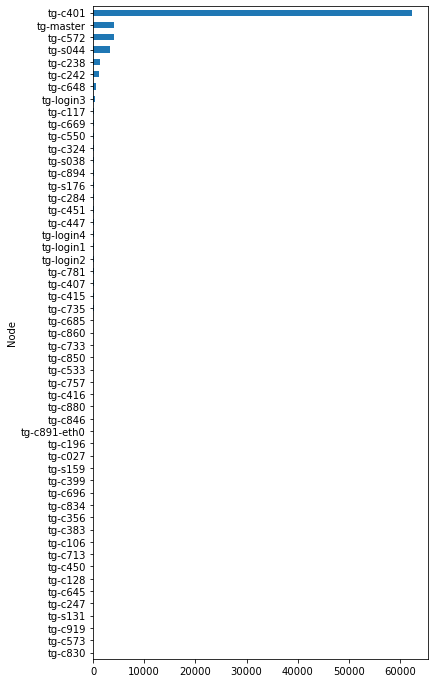

In [171]:
plt.figure(figsize=(6,12))
df_mercury.groupby(by='Node').Timestamp.count().sort_values().plot.barh()
plt.show()

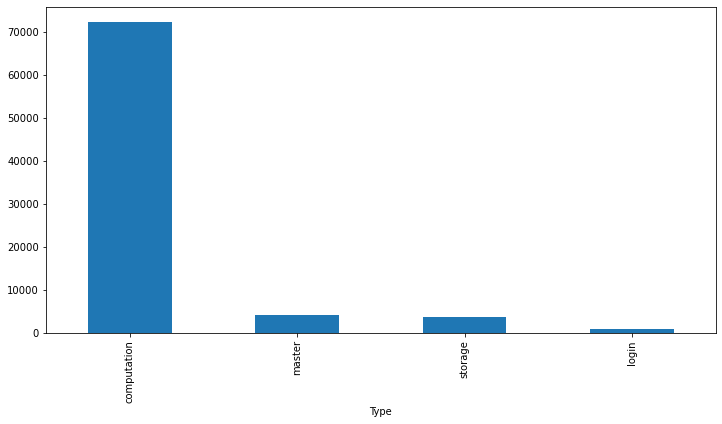

In [178]:
plt.figure(figsize=(12,6))
df_mercury.groupby(by=['Type']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.show()

### Content-based coalescence

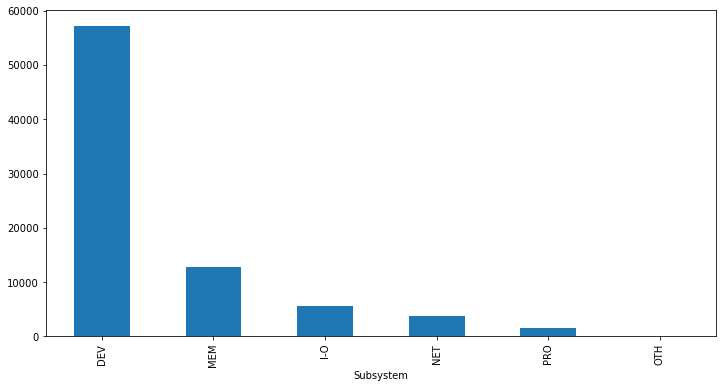

In [169]:
plt.figure(figsize=(12,6))
df_mercury.groupby(by=['Subsystem']).Timestamp.count().sort_values(ascending = False).plot.bar()
plt.show()

### mischiamo tutto!

In [138]:
df_mercury.groupby(by=['Tuple','Node']).count()

Timestamp  Subsystem  Message
Tuple Node                                    
0     tg-c645            6          6        6
1     tg-c238            3          3        3
2     tg-c238           75         75       75
3     tg-c238            2          2        2
4     tg-c238           27         27       27
...                    ...        ...      ...
466   tg-master          4          4        4
467   tg-c128            2          2        2
      tg-c196            2          2        2
      tg-master        558        558      558
468   tg-c196            2          2        2

[547 rows x 3 columns]